# Pneumonia Detection - Best Model Entry Settings

In [ ]:
#check the gpu availability
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive')

In [14]:
#import relevant libraries and tools
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Average

# Data Exploration

In [15]:
cd /content/drive/MyDrive/Pneumonia Detection/

/content/drive/MyDrive/Pneumonia Detection


In [16]:
#check the number of train images
train_image_dir = '/content/drive/MyDrive/Pneumonia Detection/train_images/train_images'

num_train_images = len(os.listdir(train_image_dir))

# Print the number of images
print("Number of train images:", num_train_images)

Number of train images: 4672


In [17]:
#check the number of test images
test_image_dir = '/content/drive/MyDrive/Pneumonia Detection/test_images/test_images'

num_test_images = len(os.listdir(test_image_dir))

# Print the number of images
print("Number of test images:", num_test_images)

Number of test images: 1168


In [18]:
#check the number of records in the csv file

# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Pneumonia Detection/labels_train.csv")

# Get the number of rows
num_rows = len(df)

# Print the number of rows
print("Number of rows:", num_rows)

Number of rows: 4672


In [19]:
#get a taste of what the csv file looks like
df.head()

,file_name,class_id
0,img_4358977458434011046.jpg,1
1,img_5224016757187192130.jpg,2
2,img_3065202206106254707.jpg,2
3,img_6304894865561547174.jpg,1
4,img_3371338542810939877.jpg,2


In [20]:
#create a function to get the train data

image_size = 224
# Load the labels from a CSV file
labels_df = pd.read_csv('/content/drive/MyDrive/Pneumonia Detection/labels_train.csv')

def get_training_data(data_dir):
    data = [] 
    for index, row in labels_df.iterrows():
        filename = row['file_name']
        label = row['class_id']
        try:
            img_arr = cv2.imread(os.path.join(data_dir, filename))
            resized_arr = cv2.resize(img_arr, (image_size, image_size)) #resize the image
            data.append([resized_arr, label])
        except Exception as e:
            print(e)
    return np.array(data)


In [21]:
#get the train data
train_data = get_training_data('train_images/train_images/')

<ipython-input-20-87d796161140>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Text(0.5, 1.0, '2')

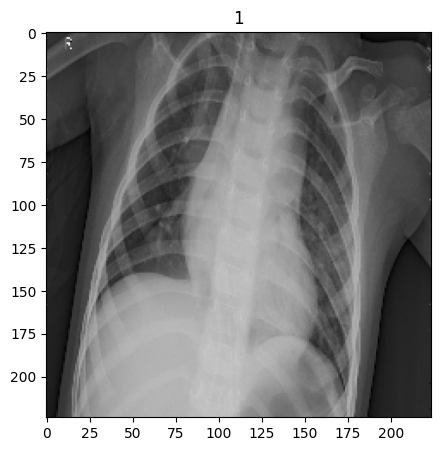

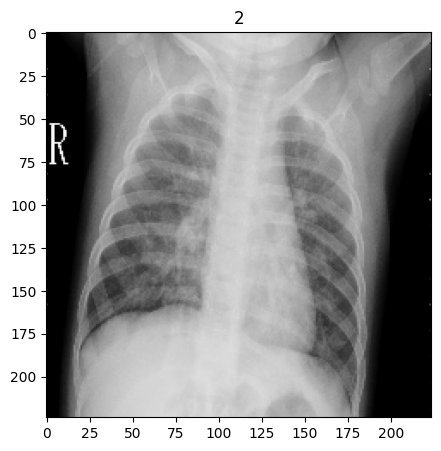

In [22]:
#see the first and last image
plt.figure(figsize = (5,5))
plt.imshow(train_data[0][0])
plt.title(train_data[0][1])

plt.figure(figsize = (5,5))
plt.imshow(train_data[1][0])
plt.title(train_data[1][1])

## Handling the imballance class issue

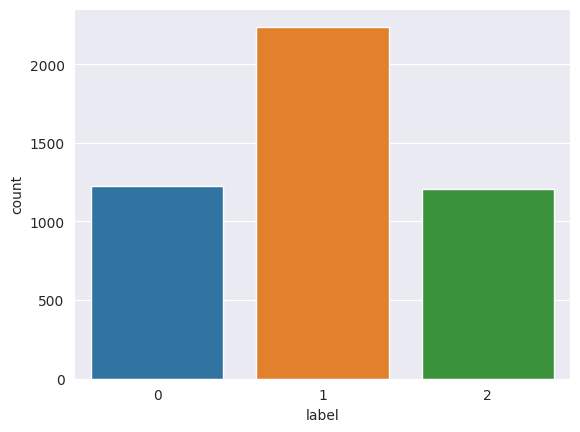

In [23]:
# Convert the training data to a pandas DataFrame
df_train = pd.DataFrame(train_data, columns=["image", "label"])

sns.set_style('darkgrid')

sns.countplot(x="label", data=df_train)

plt.show()

In [24]:
#check the distribution of the target variable
df_train.label.value_counts()

1    2238
0    1227
2    1207
Name: label, dtype: int64

In [25]:
#store the count of each class to variables
count_class1, count_class0, count_class2 = df_train.label.value_counts()

In [26]:
count_class0

1227

In [27]:
count_class1

2238

In [28]:
count_class2

1207

In [29]:
#get the dataframe for each class
df_class_0 = df_train[df_train['label']==0]

df_class_1 = df_train[df_train['label']==1]

df_class_2 = df_train[df_train['label']==2]

In [30]:
df_class_0.shape, df_class_1.shape, df_class_2.shape

((1227, 2), (2238, 2), (1207, 2))

In [31]:

#randomly sample a specific number of records for each class
df_class_0_over = df_class_0.sample(count_class1, replace=True)

df_class_2_over = df_class_2.sample(count_class1, replace=True)

In [32]:
df_class_0_over.shape, df_class_2_over.shape

((2238, 2), (2238, 2))

In [33]:
#concatenate the sampled dataframes for all classes into a single dataframe
df_train_ballanced = pd.concat([df_class_0_over, df_class_1, df_class_2_over], axis=0)

In [34]:
df_train_ballanced.shape

(6714, 2)

In [35]:
df_train_ballanced.label.value_counts()

0    2238
1    2238
2    2238
Name: label, dtype: int64

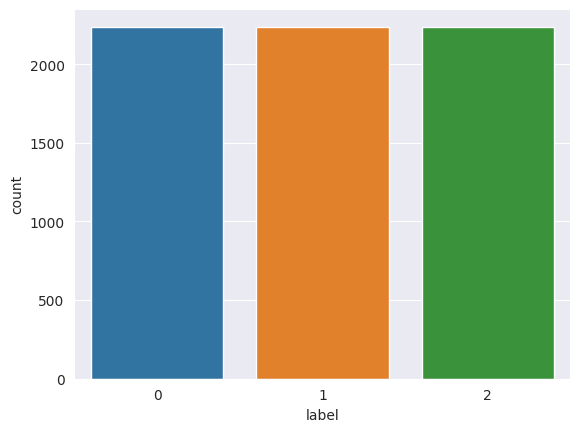

In [36]:
sns.countplot(x="label", data=df_train_ballanced)

plt.show()

In [37]:
df_train_ballanced.shape

(6714, 2)

In [38]:
#convert the ballanced dataframe into a numpy variable
train_data = df_train_ballanced.to_numpy()

## Train Test Split the data

In [39]:
# Split the data into input features and labels
X_train_data = np.array([i for i in train_data[:,0]])
y_train_data = np.array([i for i in train_data[:,1]])

In [40]:
X_train_data[0].shape

(224, 224, 3)

In [41]:
X_train_data.shape

(6714, 224, 224, 3)

In [42]:
y_train_data.shape

(6714,)

In [43]:
#Split the data into train and test parts
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=42, stratify=y_train_data)

In [44]:
X_train.shape

(4699, 224, 224, 3)

In [45]:
y_train.shape

(4699,)

## Standard - Normalize

In [46]:
#reshape the numpy arrays to match the standardization process
X_train = np.reshape(X_train, [-1,224,224,3])
X_test = np.reshape(X_test, [-1,224,224,3])

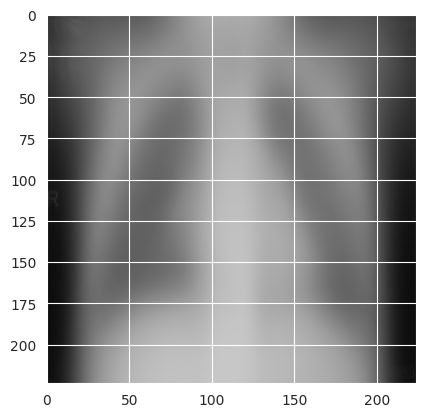

In [47]:
# Normalize data.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Subtract pixel mean
X_train_mean = np.mean(X_train, axis=0)
X_train -= X_train_mean
X_test -= X_train_mean

plt.imshow(X_train_mean)

plt.show()

In [48]:
y_train_data.shape

(6714,)

In [49]:
y_train.shape

(4699,)

## Data Augmentation

In [50]:
#generate more images based on the below changes
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=(0.8, 1.0),
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    cval=0.15
)

datagen2 = ImageDataGenerator()


datagen.fit(X_train)
datagen2.fit(X_test)

train_gen = datagen.flow(X_train, y_train)
test_gen = datagen2.flow(X_test, y_test)

# Model Construction

## First Model

In [63]:
#use Xception pretrained model from keras applications
Xception = tf.keras.applications.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

#Xception.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [64]:
#model construction architecture
inputs = tf.keras.Input(shape=(224, 224, 3))

pretrained_model = Xception(inputs)

dense = tf.keras.layers.Dense(3942, activation='relu')(pretrained_model)

x = tf.keras.layers.BatchNormalization()(dense)  # Add batch normalization layer

x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout layer

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model1 = tf.keras.Model(inputs, outputs)


print(model1.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 3942)              8077158   
                                                                 
 batch_normalization_7 (Batc  (None, 3942)             15768     
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 3942)              0         
                                                                 
 dense_7 (Dense)             (None, 3)                 11829     
                                                           

In [65]:
#compile the model
model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [66]:
#define the callbacks
callbacks = [ 
    EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2), 
    ModelCheckpoint('/content/drive/MyDrive/Pneumonia Detection/Xception with 3942 neurons/model-{epoch:02d}-{val_loss:2f}-{val_accuracy:2f}.hdf5', monitor='val_accuracy' , save_best_only=True) # saving the best model
]

In [67]:
model1.load_weights('/content/drive/MyDrive/Pneumonia Detection/Model with 3942 neurons/model-02-0.273505-0.913626.hdf5')

In [ ]:
#train the model
history1 = model1.fit(train_gen,epochs=100, 
                    validation_data=test_gen,
                    callbacks=callbacks,
                    batch_size=52)

From the first model, the best weights regarding the lowest validation loss were kept after applying weight warm starting. Specifically, the model resulted in 27.35% validation loss and 91.36% validation accuracy.

## Second Model

In [69]:
#use Xception pretrained model from keras applications
Xception = tf.keras.applications.Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

#Xception.trainable = False

In [70]:
#model construction architecture
inputs = tf.keras.Input(shape=(224, 224, 3))

pretrained_model = Xception(inputs)

dense = tf.keras.layers.Dense(942, activation='relu')(pretrained_model)

x = tf.keras.layers.BatchNormalization()(dense)  # Add batch normalization layer

x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout layer

outputs = tf.keras.layers.Dense(3, activation='softmax')(x)


model2 = tf.keras.Model(inputs, outputs)


print(model2.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_8 (Dense)             (None, 942)               1930158   
                                                                 
 batch_normalization_12 (Bat  (None, 942)              3768      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 942)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 2829      
                                                           

In [71]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [72]:
#define the callbacks
callbacks = [ 
    EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights=True), 
    ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2), 
    ModelCheckpoint('/content/drive/MyDrive/Pneumonia Detection/Model with 942 neurons/model-{epoch:02d}-{val_loss:2f}-{val_accuracy:2f}.hdf5', monitor='val_accuracy' , save_best_only=True) # saving the best model
]

In [88]:
model2.load_weights('/content/drive/MyDrive/Pneumonia Detection/Model with 942 neurons/model-02-0.249167-0.923306.hdf5')

In [ ]:
#train the model
history2 = model2.fit(train_gen,epochs=100, 
                    validation_data=test_gen,
                    callbacks=callbacks,
                    batch_size=52)

From the second model, the best weights regarding the lowest validation loss were kept after applying weight warm starting. Specifically, the model resulted in 24.92% validation loss and 92.33% validation accuracy.

## Ensemble Model

In [ ]:
#load the first and second model
model_1 = load_model('/content/drive/MyDrive/Pneumonia Detection/Model with 3942 neurons/model-02-0.273505-0.913626.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/Pneumonia Detection/Model with 942 neurons/model-02-0.249167-0.923306.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
#create the ensemble model
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.summary()

In [91]:
#compile the ensemble model
ensemble_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.00001),metrics=['accuracy'])

In [92]:
#define the callbacks
callbacks = [ 
    EarlyStopping(monitor = 'val_accuracy', patience = 4, restore_best_weights=True),
    ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2), 
    ModelCheckpoint('/content/drive/MyDrive/Pneumonia Detection/ensemble model/model-{epoch:02d}-{val_loss:2f}-{val_accuracy:2f}.hdf5', monitor='val_accuracy' , save_best_only=True) # saving the best model
]

In [ ]:
history_ensemble_model = ensemble_model.fit(train_gen,epochs=100, 
                                          validation_data=test_gen,
                                          callbacks=callbacks,
                                          batch_size=32)

From the ensemble model, the best weights regarding the lowest validation loss were kept. Specifically, the model resulted in 28.05% validation loss and 91.66% validation accuracy.

# Model Prediction

## Load the best weights of the ensemble model

In [94]:
#load the ensemble model with the best weights
ensemble_model.load_weights('/content/drive/MyDrive/Pneumonia Detection/ensemble model/model-01-0.280530-0.916605.hdf5')

In [95]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 name_of_model_1 (Functional)   (None, 3)            28966235    ['input_10[0][0]']               
                                                                                                  
 name_of_model_2 (Functional)   (None, 3)            22798235    ['input_10[0][0]']               
                                                                                                  
 average (Average)              (None, 3)            0           ['name_of_model_1[0][0]', 

In [ ]:
ensemble_model.evaluate(test_gen)

## Get the test data

In [98]:
#create a function to get the train data
def get_test_data(data_dir):
    data = []
    for file_name in os.listdir(data_dir):
        try:
            img_arr = cv2.imread(os.path.join(data_dir, file_name))
            resized_arr = cv2.resize(img_arr, (image_size, image_size)) #resize the image
            data.append([resized_arr, file_name])
        except Exception as e:
            print(e)
    return np.array(data)


In [ ]:
#get the test data
test_data = get_test_data('test_images/test_images/')

## Make Predictions

In [ ]:
# Create a Pandas DataFrame to store the image names and their predicted labels
predictions_df = pd.DataFrame(columns=['file_name', 'class_id'])

# Loop over the test data again and add the image names and their predicted labels to the DataFrame
for i, img in enumerate(test_data):
    image_name = img[1]
    
    
    img_arr = cv2.resize(img[0], (image_size, image_size)) #resize the image
    img_arr = img_arr.reshape(-1, image_size, image_size, 3) #reshape iamges to match the standardization process

    # Normalize data.
    img_arr = img_arr.astype('float32') / 255.0

    # Subtract pixel mean|
    img_arr -= X_train_mean
    
    # Predict the label for the current image
    prediction = ensemble_model.predict(img_arr)
    predicted_class = np.argmax(prediction)
    
    # Store the image name and its predicted label in a DataFrame
    predictions_df.loc[i] = [image_name, predicted_class]

In [ ]:
predictions_df.shape

In [102]:
#store the predictions to the specific directory
predictions_df.to_csv('/content/drive/MyDrive/Pneumonia Detection/Prediction csv files/prediction_66.csv', index=False)